In [65]:
import sys
sys.path.append('../')
sys.path.append('../data')
sys.path.append('../script')

import torch
from transformer_lens import HookedTransformer
import json
from src.model import WrapHookedTransformer
from tqdm import tqdm

import transformer_lens.utils as utils
from transformer_lens.utils import get_act_name
from functools import partial
from transformer_lens import patching

import json

%load_ext autoreload
%autoreload 2


In [2]:
data = json.load(open('../data/target_win_dataset_gpt2small.json'))

In [93]:
model = WrapHookedTransformer.from_pretrained('gpt2')

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [96]:
model.predict("Google One, from conflic Google One, from")

(tensor([9.9924]), [' Google'])

In [4]:
logits, cache = model.run_with_cache(data[0]['prompt'])

In [5]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [6]:
# create a single string from all the text
text = ""
for i in range(len(data)):
    text += data[i]['prompt']

In [7]:
tokens = model.to_tokens(text)
input_embedding = model.embed(tokens)

In [12]:
noise_std = (input_embedding.var(-2)).squeeze(0) 
print(noise_std.shape)
print(noise_std.mean())
noise_mean = input_embedding.mean(-2).squeeze(0)
print(noise_mean.shape)
torch.save(noise_mean, '../data/noise_mean.pt')
torch.save(noise_std, '../data/noise_std.pt')

torch.Size([768])
tensor(0.0098)
torch.Size([768])


In [9]:
input_embedding.mean(-2).mean(-1).mean(0)

tensor(-1.5522e-10)

In [61]:
input_embedding.var(-2).mean(-1).mean(0)

tensor(0.0098)

## Continuity 

In [73]:
import matplotlib.pyplot as plt
import numpy as np

target_win = np.load("../script/data/target_win_gpt2small.npy")
orthogonal_win = np.load("../script/data/orthogonal_win_gpt2small.npy")
target_win_over_orthogonal_win = np.load("../script/data/target_win_over_orthogonal_gpt2small.npy")

(10, 20)


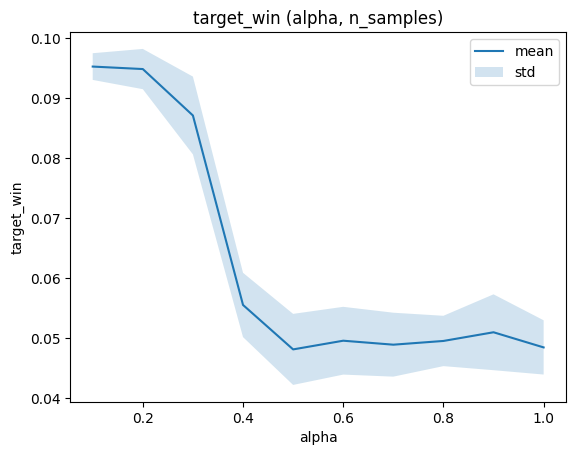

In [119]:
# target_win (alpha, n_samples). Plot the mean of the target_win over the n_samples and the variance of the target_win over the n_samples
target_win = np.load("../script/data/target_win_gpt2small.npy")
orthogonal_win = np.load("../script/data/orthogonal_win_gpt2small.npy")
target_win__ = target_win[1:, :]
alpha_values = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.plot(alpha_values[1:], target_win__.mean(-1), label="mean")
# plt.plot(alpha_values, orthogonal_win.mean(-1), label="orthogonal")
plt.fill_between(alpha_values[1:], target_win__.mean(-1) - target_win__.std(-1), target_win__.mean(-1) + target_win__.std(-1), alpha=0.2, label="std")
plt.xlabel("alpha")
plt.ylabel("target_win")
plt.legend()
plt.title("target_win (alpha, n_samples)")
plt.show()


In [82]:
len([x for x in np.arange(0.0, 0.5, 0.01)])

50

Text(0, 0.5, 'Percentage of factual recovery')

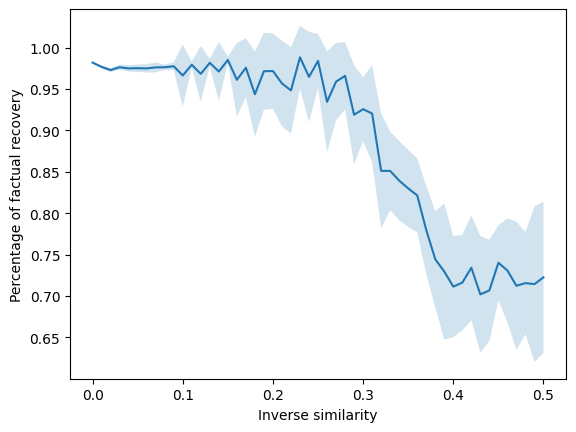

In [92]:
# target_win (alpha, n_samples). Plot the mean of the target_win over the n_samples and the variance of the target_win over the n_samples
target_win = np.load("../results/target_win_gpt2small_alpha.npy")
# orthogonal_win = np.load("../script/data/orthogonal_win_gpt2small.npy")
plt.plot(target_win.mean(-1), label="mean")
plt.fill_between(np.arange(len(target_win)), target_win.mean(-1) - target_win.std(-1), target_win.mean(-1) + target_win.std(-1), alpha=0.2, label="std")
#change the xticks
plt.xticks(np.arange(0, len(target_win), 10), np.arange(0, len(target_win), 10)/100)
plt.xlabel("Inverse similarity")
plt.ylabel("Percentage of factual recovery")


In [75]:
target_win.shape

(51, 10)

# dataset statistics

In [97]:
import json
target_small = json.load(open("../data/target_win_dataset_gpt2small.json"))
orthogonal_small = json.load(open("../data/orthogonal_win_dataset_gpt2small.json"))
target_xl = json.load(open("../data/target_win_dataset_gpt2-xl.json"))
orthogonal_xl = json.load(open("../data/orthogonal_win_dataset_gpt2-xl.json"))

In [21]:
import numpy as np

In [98]:
dataset = {
    "memorizing_win": target_small,
    "copying_win": orthogonal_small
}
json.dump(dataset, open("../data/dataset_gpt2.json", "w"))

In [90]:
target_small

[{'prompt': 'Android is created by',
  'target': ' Google',
  'premise': 'Android is created byAl Android is created by',
  'orthogonal_token': 'Al',
  'length': 10.0,
  'target_probs': 0.06647113710641861,
  'orthogonal_probs': 0.0064841387793421745},
 {'prompt': 'Xbox, created by',
  'target': ' Microsoft',
  'premise': 'Xbox, created by Scully Xbox, created by',
  'orthogonal_token': ' Scully',
  'length': 10.0,
  'target_probs': 0.026544099673628807,
  'orthogonal_probs': 0.01093737781047821},
 {'prompt': 'Android is developed by',
  'target': ' Google',
  'premise': 'Android is developed by compat Android is developed by',
  'orthogonal_token': ' compat',
  'length': 10.0,
  'target_probs': 0.05834359675645828,
  'orthogonal_probs': 0.0029857864137738943},
 {'prompt': 'Boston, founded in',
  'target': ' Boston',
  'premise': 'Boston, founded inWP Boston, founded in',
  'orthogonal_token': 'WP',
  'length': 10.0,
  'target_probs': 0.043614309281110764,
  'orthogonal_probs': 0.00222

In [63]:
target_small = [d for d in target_small if d["target_probs"] < 0.2]

In [64]:
json.dump(target_small, open("../data/target_win_dataset_gpt2small_filtered.json", "w"))

In [54]:
orthogonal_small = [d for d in orthogonal_small if d["orthogonal_probs"] < 0.2]

In [55]:
target_small_prob = [d["target_probs"] for d in target_small]
orthogonal_small_prob = [d["orthogonal_probs"] for d in orthogonal_small]

#print mean and std of the target_win
print(np.array(target_small_prob).mean())
print(np.array(target_small_prob).std())
print(np.array(orthogonal_small_prob).mean())
print(np.array(orthogonal_small_prob).std())

0.11062361236979877
0.08034123314948943
0.10580221487642578
0.049550247036798646


[0.03400483354926109,
 0.02734527550637722,
 0.04647824540734291,
 0.04248309135437012,
 0.06255055963993073,
 0.07468491047620773,
 0.058295223861932755,
 0.0468791201710701,
 0.09983042627573013,
 0.08424754440784454,
 0.06654061377048492,
 0.06314319372177124,
 0.017792154103517532,
 0.08503511548042297,
 0.05288657918572426,
 0.09934479743242264,
 0.09544812887907028,
 0.08322865515947342,
 0.04127630218863487,
 0.08266543596982956,
 0.035627931356430054,
 0.09818695485591888,
 0.04667206481099129,
 0.084453284740448,
 0.06381871551275253,
 0.09487159550189972,
 0.07650048285722733,
 0.03341135010123253,
 0.05443607643246651,
 0.049364686012268066,
 0.0805172249674797,
 0.032958343625068665,
 0.04564966261386871,
 0.0404173918068409,
 0.06568101048469543,
 0.03107396699488163,
 0.08303968608379364,
 0.0823415219783783,
 0.054688211530447006,
 0.05820469185709953,
 0.043772272765636444,
 0.06361999362707138,
 0.06624403595924377,
 0.03859661892056465,
 0.05395475775003433,
 0.007245

## noise

In [16]:
import sys
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../data')

import torch
from transformer_lens import HookedTransformer
import json
from src.patching import get_act_patch_mlp_out
from src.model import WrapHookedTransformer
from src.dataset import Dataset
import transformer_lens.utils as utils
from transformer_lens.utils import get_act_name
from functools import partial
from transformer_lens import patching
import plotly.express as px
import random
from src.utils import (
    embs_to_tokens_ids,
    patch_resid_pre,
    patch_attn_head_out_all_pos,
    patch_attn_head_by_pos,
    patch_per_block_all_poss,
    patch_attn_head_all_pos_every,
    logit_lens,
    list_of_dicts_to_dict_of_lists,
)


def dict_of_lists_to_dict_of_tensors(dict_of_lists):
    dict_of_tensors = {}
    for key, tensor_list in dict_of_lists.items():
        # If the key is "example_str_token", keep it as a list of strings
        if key == "example_str_token" or key == "logit_lens":
            dict_of_tensors[key] = tensor_list
            continue
        
        # Check if the first element of the list is a tensor
        if isinstance(tensor_list[0], torch.Tensor):
            dict_of_tensors[key] = torch.stack(tensor_list)
        # If the first element is a list, convert each inner list to a tensor and then stack
        elif isinstance(tensor_list[0], list):
            tensor_list = [torch.tensor(item) for item in tensor_list]
            dict_of_tensors[key] = torch.stack(tensor_list)
        else:
            print(f"Unsupported data type for key {key}: {type(tensor_list[0])}")
            raise ValueError(f"Unsupported data type for key {key}: {type(tensor_list[0])}")
    return dict_of_tensors

torch.set_grad_enabled(False)

MODEL_NAME = "gpt2small"
MAX_LEN = 14
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = WrapHookedTransformer.from_pretrained("gpt2", device=DEVICE)
target_data = json.load(open("../data/target_win_dataset_{}.json".format(MODEL_NAME)))
orthogonal_data = json.load(
    open("../data/orthogonal_win_dataset_{}.json".format(MODEL_NAME))
)
orthogonal_data = random.sample(orthogonal_data, len(target_data))
dataset = Dataset(target_data, orthogonal_data, model)
dataset.random_sample(500, 14)


dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)


pos_result = []
neg_result = []
pos_result_var = []
neg_result_var = []
for batch in dataloader:

    pos_batch = batch["pos_dataset"]
    neg_batch = batch["neg_dataset"]
    pos_target_ids = {
        "target": model.to_tokens(pos_batch["target"], prepend_bos=False),
        "orthogonal": model.to_tokens(pos_batch["orthogonal_token"], prepend_bos=False),
    }
    neg_target_ids = {
        "target": model.to_tokens(neg_batch["target"], prepend_bos=False),
        "orthogonal": model.to_tokens(neg_batch["orthogonal_token"], prepend_bos=False),
    }
    pos_input_ids = model.to_tokens(pos_batch["premise"], prepend_bos=True)
    neg_input_ids = model.to_tokens(neg_batch["premise"], prepend_bos=True)
    pos_embs_corrupted = model.add_noise(
        pos_batch["premise"],
        noise_index = torch.tensor([1,2,3,7]),
        target_win=7,
        noise_mlt=20
    )
    neg_embs_corrupted = model.add_noise(
        neg_batch["premise"],
        noise_index = torch.tensor([1,2,3,7]),
        target_win=7,
        noise_mlt=16
    )

    pos_corrupted_logit, pos_corrupted_cache = model.run_with_cache_from_embed(pos_embs_corrupted)
    pos_clean_logit, pos_clean_cache = model.run_with_cache(pos_batch["premise"])
    neg_corrupted_logit, neg_corrupted_cache = model.run_with_cache_from_embed(neg_embs_corrupted)
    neg_clean_logit, neg_clean_cache = model.run_with_cache(neg_batch["premise"])

    def indirect_effect(logits, corrupted_logits, first_ids_pos):
        logits = torch.softmax(logits, dim=-1)
        corrupted_logits = torch.softmax(corrupted_logits, dim=-1)
        batch_index = torch.arange(logits.shape[0])
        delta_value = (
            logits[batch_index, -1, first_ids_pos] - corrupted_logits[batch_index, -1, first_ids_pos]
        )
        return delta_value.mean(), delta_value.var()

    pos_metric = partial(
        indirect_effect,
        corrupted_logits=pos_corrupted_logit,
        first_ids_pos=pos_target_ids["target"]
    )
    neg_metric = partial(
        indirect_effect,
        corrupted_logits=neg_corrupted_logit,
        first_ids_pos=neg_target_ids["orthogonal"]
    )
    pos_result.append(pos_metric(logits=pos_clean_logit)[0])
    neg_result.append(neg_metric(logits=neg_clean_logit)[0])
    pos_result_var.append(pos_metric(logits=pos_clean_logit)[1])
    neg_result_var.append(neg_metric(logits=neg_clean_logit)[1])



Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer
possible_lengths for sampling 500: [14.0, 16.0, 18.0]


In [17]:
pos_result

[tensor(0.0044),
 tensor(0.0061),
 tensor(0.0087),
 tensor(0.0071),
 tensor(0.0068)]

In [14]:
pos_result_var

[tensor(0.0014),
 tensor(0.0021),
 tensor(0.0019),
 tensor(0.0012),
 tensor(0.0017)]

In [11]:
torch.stack(pos_result_var)

tensor([0.0012, 0.0022, 0.0016, 0.0015, 0.0017])

In [18]:
neg_result

[tensor(0.0045),
 tensor(0.0040),
 tensor(0.0041),
 tensor(0.0042),
 tensor(0.0042)]

In [5]:
neg_result_var

[tensor(0.0017),
 tensor(0.0017),
 tensor(0.0019),
 tensor(0.0020),
 tensor(0.0014)]